In [61]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Filename for saved plots

In [62]:
season = 'WET'

In [63]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_ATTO_{season}_{comment}_{case}_{_x}_{_y}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

In [64]:
high_low_vars = ['N50','N100','N150','N200','N100 (cm^-3)']

In [65]:
from bs_fdbck.constants import path_measurement_data

In [66]:
fn = path_measurement_data / 'SourceData_Yli_Juuti2021.xls'

df_hyy_1 = pd.read_excel(fn, sheet_name=4, header=1,)# usecols=range(7,12),nrows=7)

df_hyy_1.head()

,year,month,day,LAT,LON,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
0,2012,7,5,60.5,22.5,3.218589,191,12.940000,26.219999
1,2012,7,10,60.5,22.5,4.714353,172,10.950000,24.430000
2,2012,7,14,60.5,22.5,1.451827,106,15.790000,12.030000
3,2012,7,19,60.5,22.5,3.101941,262,16.039999,28.650000
4,2012,7,22,60.5,22.5,0.875789,92,10.630000,14.820000


In [67]:
import pandas as pd

In [68]:
df_hyy_1['date'] = df_hyy_1.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_1['date'] = pd.to_datetime(df_hyy_1['date'] )

df_hyy_1 = df_hyy_1.set_index(['date','LAT','LON'])

In [69]:
df_hyy_1.index = df_hyy_1.index.rename({'LAT':'lat', 'LON':'lon','date':'time'})

In [70]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


## Pick up sizedist info as well

In [71]:
df_hyy_2 = pd.read_excel(fn, sheet_name=0, header=2, usecols=range(6))
df_hyy_2['date'] = df_hyy_2.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_2['date'] = pd.to_datetime(df_hyy_2['date'] )



In [72]:
from bs_fdbck.util.EBAS_data import get_ebas_dataset_Nx_daily_JA_median_df



df_ebas_Nx, ds_ebas_Nx = get_ebas_dataset_Nx_daily_JA_median_df()#x_list = [90,100,110,120])

Importing files: 
[PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20120101000000.20181205100800.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20130101000000.20220222151057.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20140101000000.20220222151057.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20150101000000.20220222151057.dmps.particle_number_size_distribution.pm10.1y.1h.FI03L_UHEL_DMPS_HYY_01.FI03L__TRY_TDMPS.lev2.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/EBAS/raw_data/SMR/FI0050R.20160101000000.2022022

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/EBAS_data/__init__.py:242: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_JA.mean()
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/EBAS_data/__init__.py:245: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_JA.median())


In [73]:

df_hyy_2['date'] = df_hyy_2.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_2['date'] = pd.to_datetime(df_hyy_2['date'] )


df_hyy_2 = df_hyy_2.set_index('date')

In [74]:
df_hyy_2.index = df_hyy_2.index.rename('time')

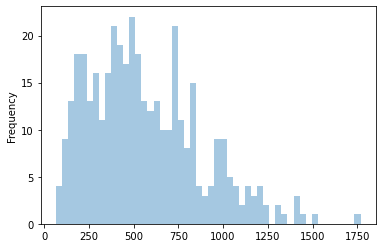

In [75]:
df_hyy_2['N100 (cm^-3)'].plot.hist(bins=50, alpha=0.4, label='obs')

plt.show()



## Why is my method 20% off their method? Is it integration?

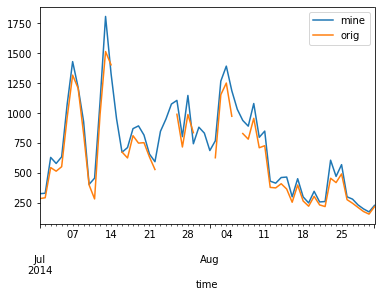

1.13207410632531


In [76]:

df_joint_hyy = pd.merge(df_ebas_Nx, df_hyy_2, left_index=True, right_index=True)
(df_joint_hyy['N100']).loc['2014-07':'2014-09'].plot(label='mine')
(df_joint_hyy['N100 (cm^-3)']).loc['2014-07':'2014-09'].plot(label='orig')
plt.legend()
plt.show()



print(df_joint_hyy['N100'][df_joint_hyy['N100 (cm^-3)'].notnull()].mean()/df_joint_hyy['N100 (cm^-3)'].mean())

In [77]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


In [78]:
take_vars = ['N50','N100','N150','N200','N100 (cm^-3)']

In [79]:
import numpy as np

In [80]:
for v in high_low_vars:
    df_hyy_1[v] = np.nan

for d in df_hyy_1.index.get_level_values(0).unique():
    #print(d)
    for v in take_vars:
        df_hyy_1.loc[d,v] = df_joint_hyy.loc[d,v]

/tmp/ipykernel_223663/3996915807.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_hyy_1.loc[d,v] = df_joint_hyy.loc[d,v]


In [81]:
for v in take_vars:
    df_hyy_1[f'{v}_low'] = df_hyy_1[v]<df_hyy_1[v].quantile(.34)
    df_hyy_1[f'{v}_high']= df_hyy_1[v]>df_hyy_1[v].quantile(.66)
    df_hyy_1[f'{v}_category'] = pd.NA#df_hyy_1.assign(OA_category= pd.NA)

    df_hyy_1.loc[df_hyy_1[f'{v}_high'], f'{v}_category'] = f'{v} high'
    df_hyy_1.loc[df_hyy_1[f'{v}_low'], f'{v}_category'] = f'{v} low'

In [82]:
high_low_vars

['N50', 'N100', 'N150', 'N200', 'N100 (cm^-3)']

In [83]:
#df_hyy_1['OA_category']

df_hyy_1['OA_low']= df_hyy_1['OA (microgram m^-3)']<2
df_hyy_1['OA_high']= df_hyy_1['OA (microgram m^-3)']>2
ddf_hyy_1=df_hyy_1.assign(OA_category= pd.NA)
df_hyy_1.loc[df_hyy_1['OA_high'], 'OA_category'] = 'OA high'
df_hyy_1.loc[df_hyy_1['OA_low'], 'OA_category'] = 'OA low'



#### Original binning from Yli-Juuti et al:

In [84]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

labels=[ 80, 120, 160, 200, 240, 280, 320]

df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
# label for each bin
df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

#### Quantile binning

In [85]:
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 7)#bins=bins, labels=labels)
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)
# Label by median in each bin
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

#### Bin from 5th to 95th quantile of CWP and label by median in each bin or just number

In [86]:
n_bins = 7
labels = np.arange(n_bins)

qants = df_hyy_1['CWP (g m^-2)'].quantile([.05,.95])

bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)

df_hyy_1['CWP_cut2']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins2, labels=labels)


di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

df_hyy_1['CWP_cut2l'] = df_hyy_1['CWP_cut2'].apply(lambda x:di_per_lab[x])


di = dict(df_hyy_1.groupby('CWP_cut2').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lm'] = df_hyy_1['CWP_cut2'].apply(lambda x:di[x])
#di = dict(df_hyy_1.groupby('CWP_cut2').mid)
#for k in di.keys():
#    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:np.round(x.mid))


#df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

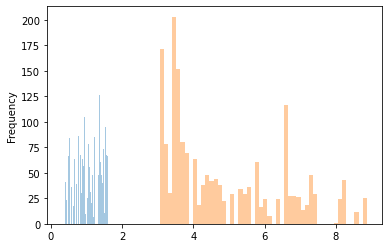

In [87]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')



## Load model data:

In [88]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 

models =[model_name_noresm,model_name_echam]

### Settings

In [89]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

### NorESM

In [90]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [91]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

In [92]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final{season}.csv'

In [93]:
cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [94]:
case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [95]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [96]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [97]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}{season}.csv'

In [98]:

cases_echam = [case_name_echam]

### Read in model data

In [99]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )

df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )

### Organize data in dictionary

In [100]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df['Observations'] = df_hyy_1

## Mask data

### NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [101]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

## Rename variables:


In [102]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    
    
}
rn_dic_noresm = {
    'TGCLDCWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [103]:
for key, rn in zip([model_name_noresm, model_name_echam,'Observations'], [rn_dic_noresm, rn_dic_echam, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path 

#### Predefined bins

In [104]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:

CWP above 50. 

In [105]:
varl_categories = ['OA']#,'CLDFREE']

In [106]:
n_bins = 7

for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))

    for v in high_low_vars:
        if v not in df_mod.columns:
            continue
        df_mod[f'{v}_low'] = df_mod[v]<df_mod[v].quantile(.34)
        df_mod[f'{v}_high']= df_mod[v]>df_mod[v].quantile(.66)
        df_mod[f'{v}_category'] = pd.NA#df_hyy_1.assign(OA_category= pd.NA)

        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'


    dic_df[model_name] = df_mod

NorESM
ECHAM-SALSA


## Quantile cut

In [107]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [108]:
palette = 'Set2'

In [109]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

3673
Plots/dist_plot/cloud_props_ATTO_WET_distribution_mod_obs_N100_category_COT_count.png


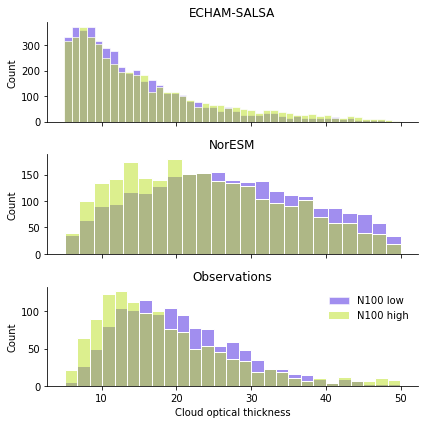

In [110]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'N100_category'
hue_order=['N100 low', 'N100 high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=hue_order[1]),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=hue_order[0]),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn(f'mod_obs_{v_hue}', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



3659
Plots/dist_plot/cloud_props_ATTO_WET_distribution_mod_obs_N100_category_CWP_count.png


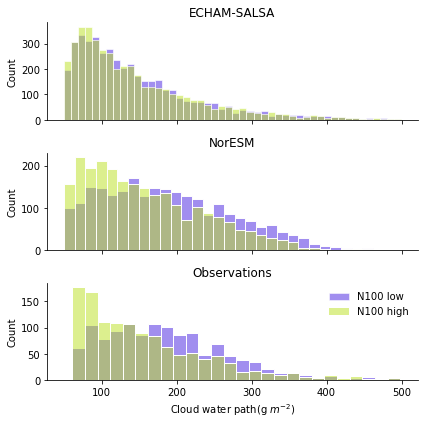

In [111]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 500
v_hue = 'N100_category'
hue_order=['N100 low', 'N100 high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]
leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=hue_order[1]),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=hue_order[0]),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn(f'mod_obs_{v_hue}', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [112]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

13127

13127
10168
3673
Plots/dist_plot/cloud_props_ATTO_WET_distribution_mod_obs_N100_category_r_eff_count.png


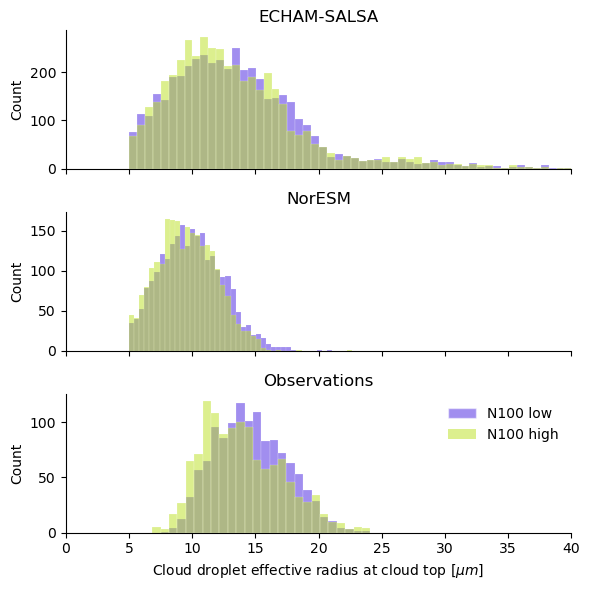

In [113]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'N100_category'
hue_order=['N100 low', 'N100 high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]


leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=hue_order[1]),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=hue_order[0]),

]


ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn(f'mod_obs_{v_hue}', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



# Calculate difference between high OA and low


In [114]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [115]:
hue_order = ['N100 low','N100 high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [116]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [117]:
from sklearn.utils import resample

## Bootstrap resampling 

In [118]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [119]:
hue_labs = ['N100 low', 'N100 high']
hue_var = 'N100_category'

itterations=50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        if key=='Observations':
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()[hue_var]
        n_high = _df_high.groupby(x_var).count()[hue_var]
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

length of 72 is 1185 and 1311
50000
length of 106 is 1123 and 1073
50000
length of 144 is 747 and 717
50000
length of 183 is 526 and 481
50000
length of 222 is 293 and 324
50000
length of 260 is 216 and 200
50000
length of 299 is 140 and 132
50000
length of 73 is 326 and 530
50000
length of 109 is 399 and 548
50000
length of 148 is 408 and 416
50000
length of 188 is 393 and 331
50000
length of 229 is 306 and 244
50000
length of 266 is 258 and 185
50000
length of 306 is 167 and 102
50000
length of 72 is 1185 and 1311
50000
length of 106 is 1123 and 1073
50000
length of 144 is 747 and 717
50000
length of 183 is 526 and 481
50000
length of 222 is 293 and 324
50000
length of 260 is 216 and 200
50000
length of 299 is 140 and 132
50000
length of 73 is 326 and 530
50000
length of 109 is 399 and 548
50000
length of 148 is 408 and 416
50000
length of 188 is 393 and 331
50000
length of 229 is 306 and 244
50000
length of 266 is 258 and 185
50000
length of 306 is 167 and 102
50000


# Final plot: 

Plots/rel_plot/cloud_props_ATTO_WET_r_eff_diff_median_N100_category_COT_CWP_cut2lmid.png


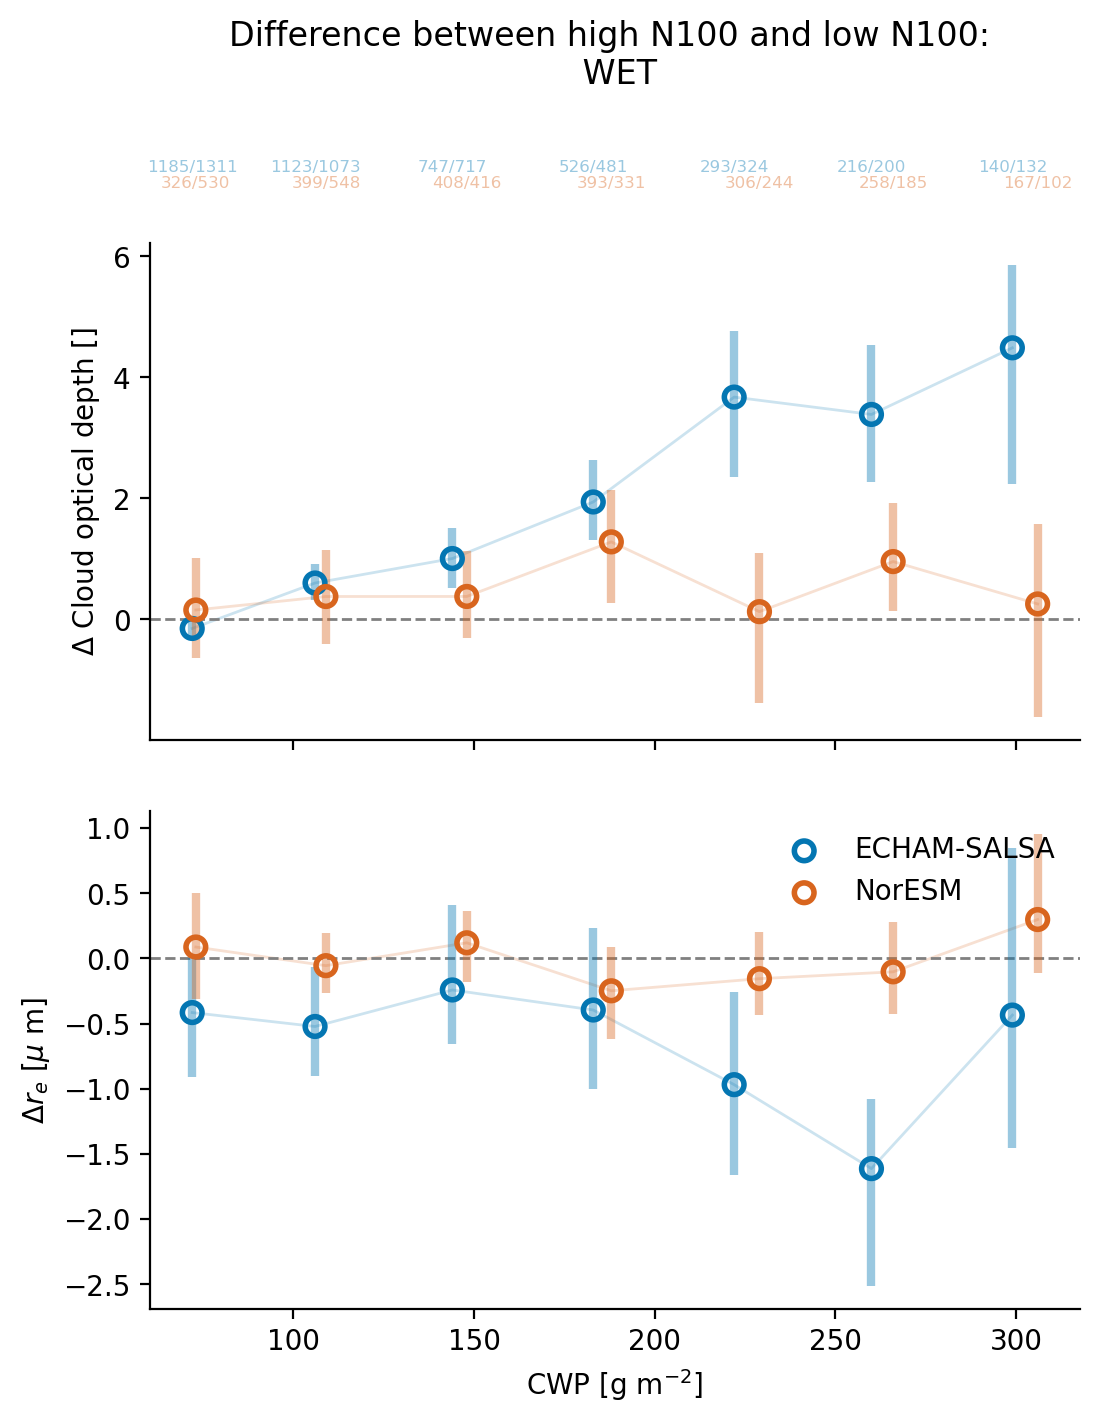

In [120]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
v_hue = 'N100_category'
hue_order=['N100 low', 'N100 high'][::-1]


ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lmid'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    for key in dic_df.keys():
        if key=='Observations':
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=key,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.4,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high N100 and low N100: \n {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

# N50

## Calculate CIs with bootstrap

In [121]:
hue_labs = ['N50 low', 'N50 high']
hue_var = 'N50_category'

itterations=50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        if key=='Observations':
            continue

        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()[hue_var]
        n_high = _df_high.groupby(x_var).count()[hue_var]
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

length of 72 is 1157 and 1301
50000
length of 106 is 1126 and 1124
50000
length of 144 is 762 and 742
50000
length of 183 is 498 and 471
50000
length of 222 is 313 and 311
50000
length of 260 is 218 and 189
50000
length of 299 is 146 and 113
50000
length of 73 is 322 and 533
50000
length of 109 is 399 and 537
50000
length of 148 is 406 and 395
50000
length of 188 is 405 and 334
50000
length of 229 is 314 and 249
50000
length of 266 is 253 and 194
50000
length of 306 is 166 and 107
50000
length of 72 is 1157 and 1301
50000
length of 106 is 1126 and 1124
50000
length of 144 is 762 and 742
50000
length of 183 is 498 and 471
50000
length of 222 is 313 and 311
50000
length of 260 is 218 and 189
50000
length of 299 is 146 and 113
50000
length of 73 is 322 and 533
50000
length of 109 is 399 and 537
50000
length of 148 is 406 and 395
50000
length of 188 is 405 and 334
50000
length of 229 is 314 and 249
50000
length of 266 is 253 and 194
50000
length of 306 is 166 and 107
50000


# Final plot: 

Plots/rel_plot/cloud_props_ATTO_WET_r_eff_diff_median_N50_category_COT_CWP_cut2lmid.png


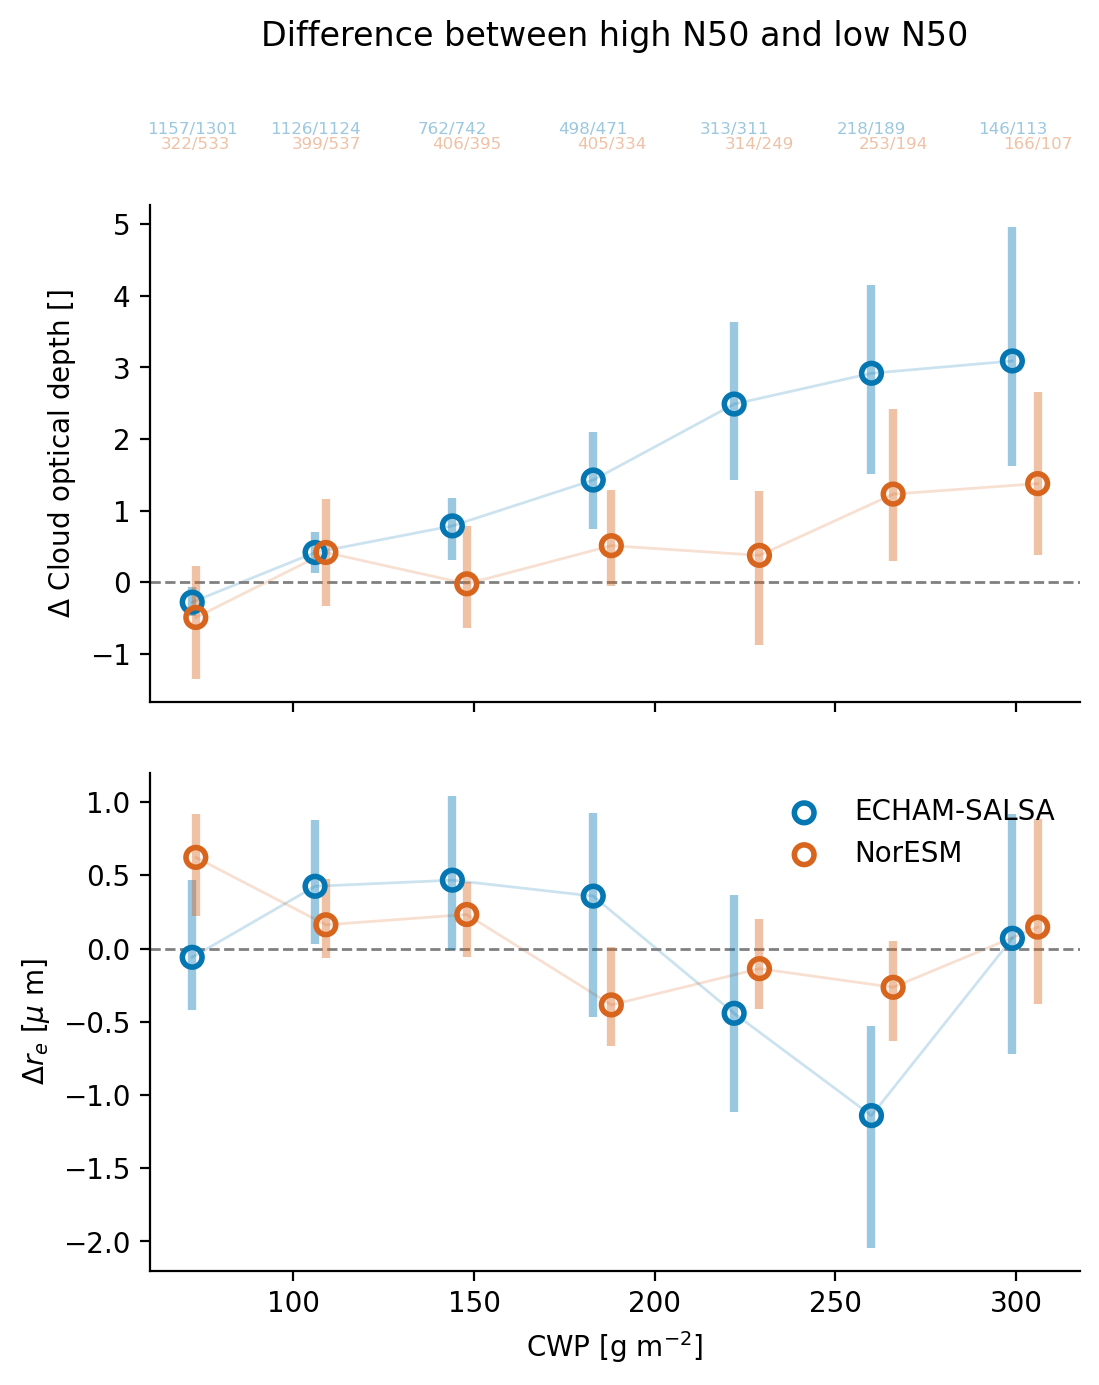

In [122]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
v_hue = 'N50_category'
hue_order=['N50 low', 'N50 high'][::-1]


ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lmid'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    for key in dic_df.keys():
        if key=='Observations':
            continue
        
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=key,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.4,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title('Difference between high N50 and low N50')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

# N200

## Calculate CIs with bootstrap

In [123]:
hue_labs = ['N200 low', 'N200 high']
hue_var = 'N200_category'

itterations=50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        if key=='Observations':
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()[hue_var] 
        n_high = _df_high.groupby(x_var).count()[hue_var]
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

length of 72 is 1228 and 1213
50000
length of 106 is 1158 and 1081
50000
length of 144 is 757 and 727
50000
length of 183 is 486 and 499
50000
length of 222 is 296 and 350
50000
length of 260 is 208 and 216
50000
length of 299 is 117 and 137
50000
length of 73 is 343 and 516
50000
length of 109 is 398 and 523
50000
length of 148 is 413 and 432
50000
length of 188 is 387 and 329
50000
length of 229 is 305 and 247
50000
length of 266 is 245 and 197
50000
length of 306 is 163 and 111
50000
length of 72 is 1228 and 1213
50000
length of 106 is 1158 and 1081
50000
length of 144 is 757 and 727
50000
length of 183 is 486 and 499
50000
length of 222 is 296 and 350
50000
length of 260 is 208 and 216
50000
length of 299 is 117 and 137
50000
length of 73 is 343 and 516
50000
length of 109 is 398 and 523
50000
length of 148 is 413 and 432
50000
length of 188 is 387 and 329
50000
length of 229 is 305 and 247
50000
length of 266 is 245 and 197
50000
length of 306 is 163 and 111
50000


# Final plot: 

Plots/rel_plot/cloud_props_ATTO_WET_r_eff_diff_median_N200_category_COT_CWP_cut2lmid.png


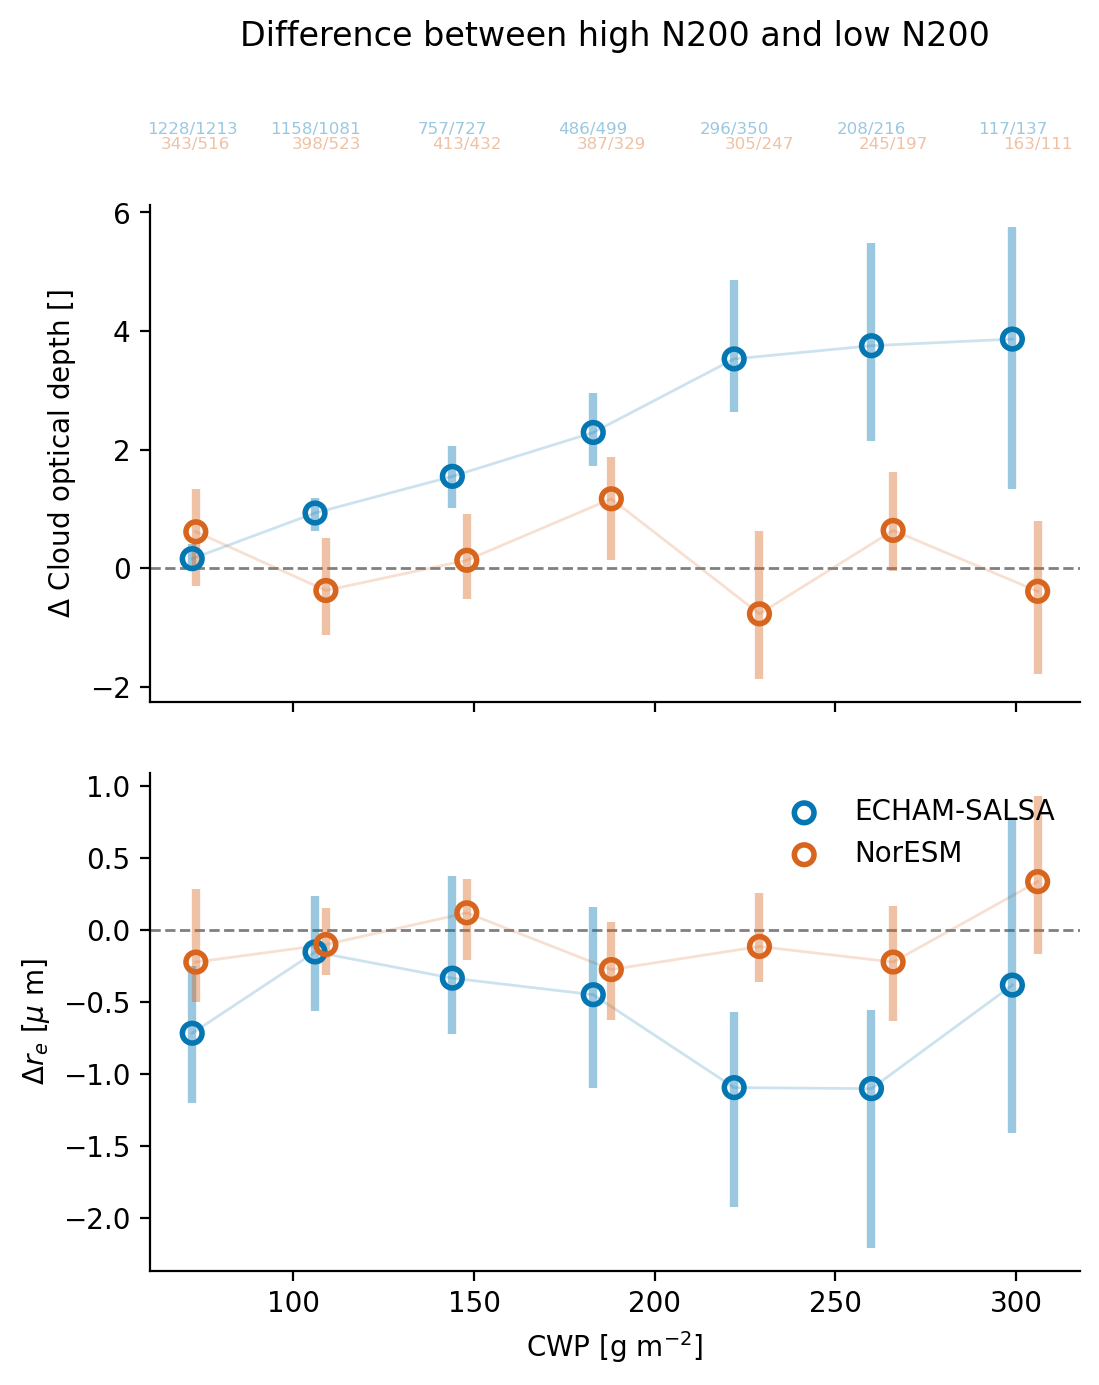

In [124]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
v_hue = 'N200_category'
hue_order=['N200 low', 'N200 high'][::-1]


ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lmid'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    for key in dic_df.keys():
        if key=='Observations':
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=key,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.4,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title('Difference between high N200 and low N200')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [125]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [126]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

KeyError: 'OA_category'

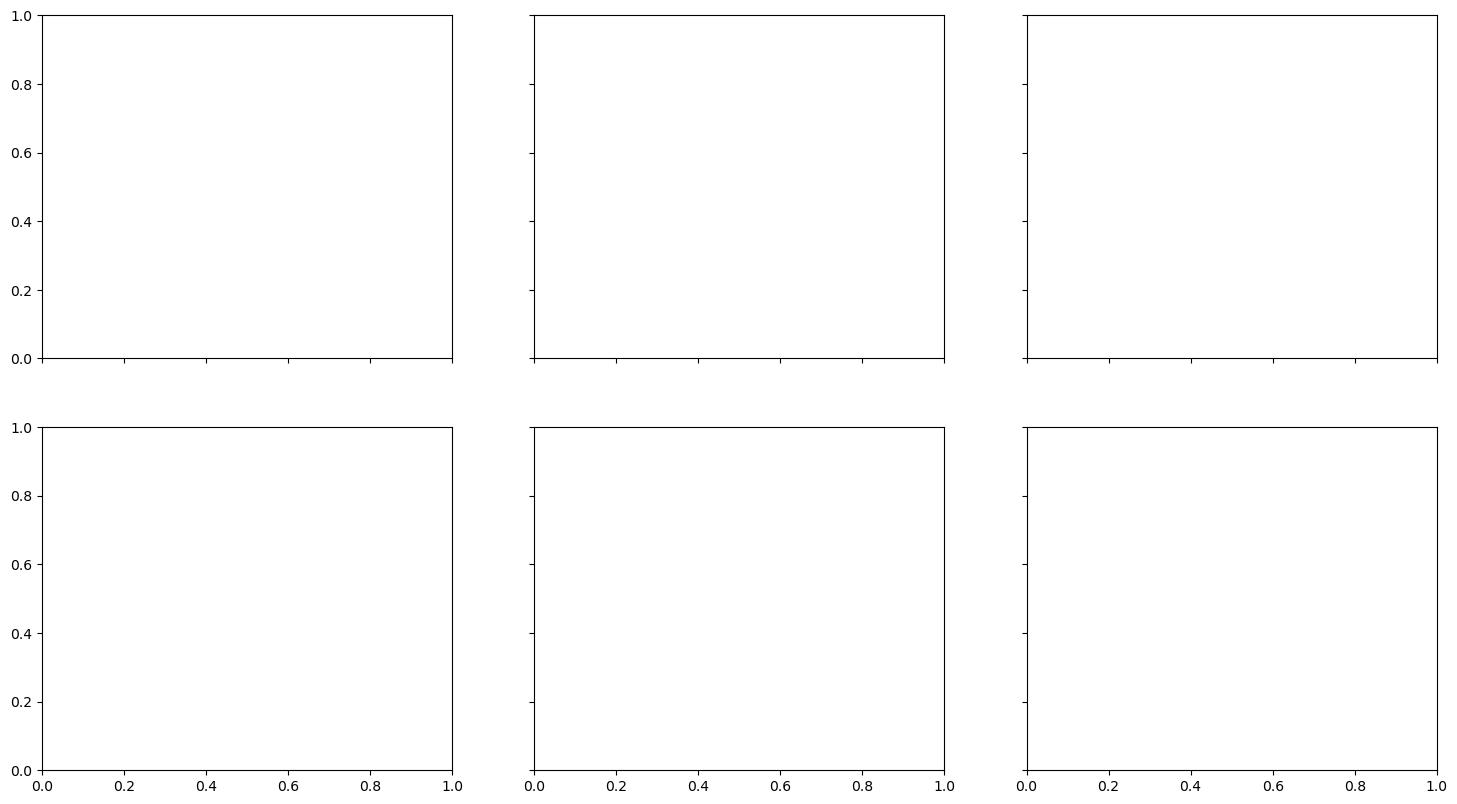

In [127]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

In [ ]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()